# Methodology Summary
In this notebook, we give an overview of the methodology.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/method.ipynb)

In [1]:
random_state = 42

In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
#...and download raw data if not already downloaded
from data_utils import init_data
init_data(syn_data_path=SYN_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_anomaly_scoring
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv)
from bench_utils import (
    classification_benchmark,
    repeat_experiment,
    aabb_classification_benchmark,
    extract_metrics)
from data_utils import (load_processed_data,
                        load_syn_reg_data,
                        FEATURE_LIST)
from LogFilterbank import LogFilterbank
from manifold_utils import tsne_embedding

time passed: 4.95 s
downloading synthetic data successful: True


## Loading Data

In [4]:
fname = Path(SYN_DATA_PATH, "0.024", r"D_R0.024_0.001875_0.000875_1.1716_1.0_1.0178_1.0397_0.9998_0.0194_.csv")

In [5]:
from data_utils import load_raw_data, _load_raw_specs

X_df, y_df = load_raw_data(fname)
spec = X_df['real'].values

## Filterbank Configuration

In [6]:
# configuration
sr = 120000 #originally from df['kHz'].iloc[-1]*1000*2 # from measurement, highest f[kHz]*2
n_log_bins = 66
n_fft = 1600
n_fft_bins = 801
f_min = 1300
f_max = 24000
norm = 'height'

fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, f_max=f_max, norm=norm)

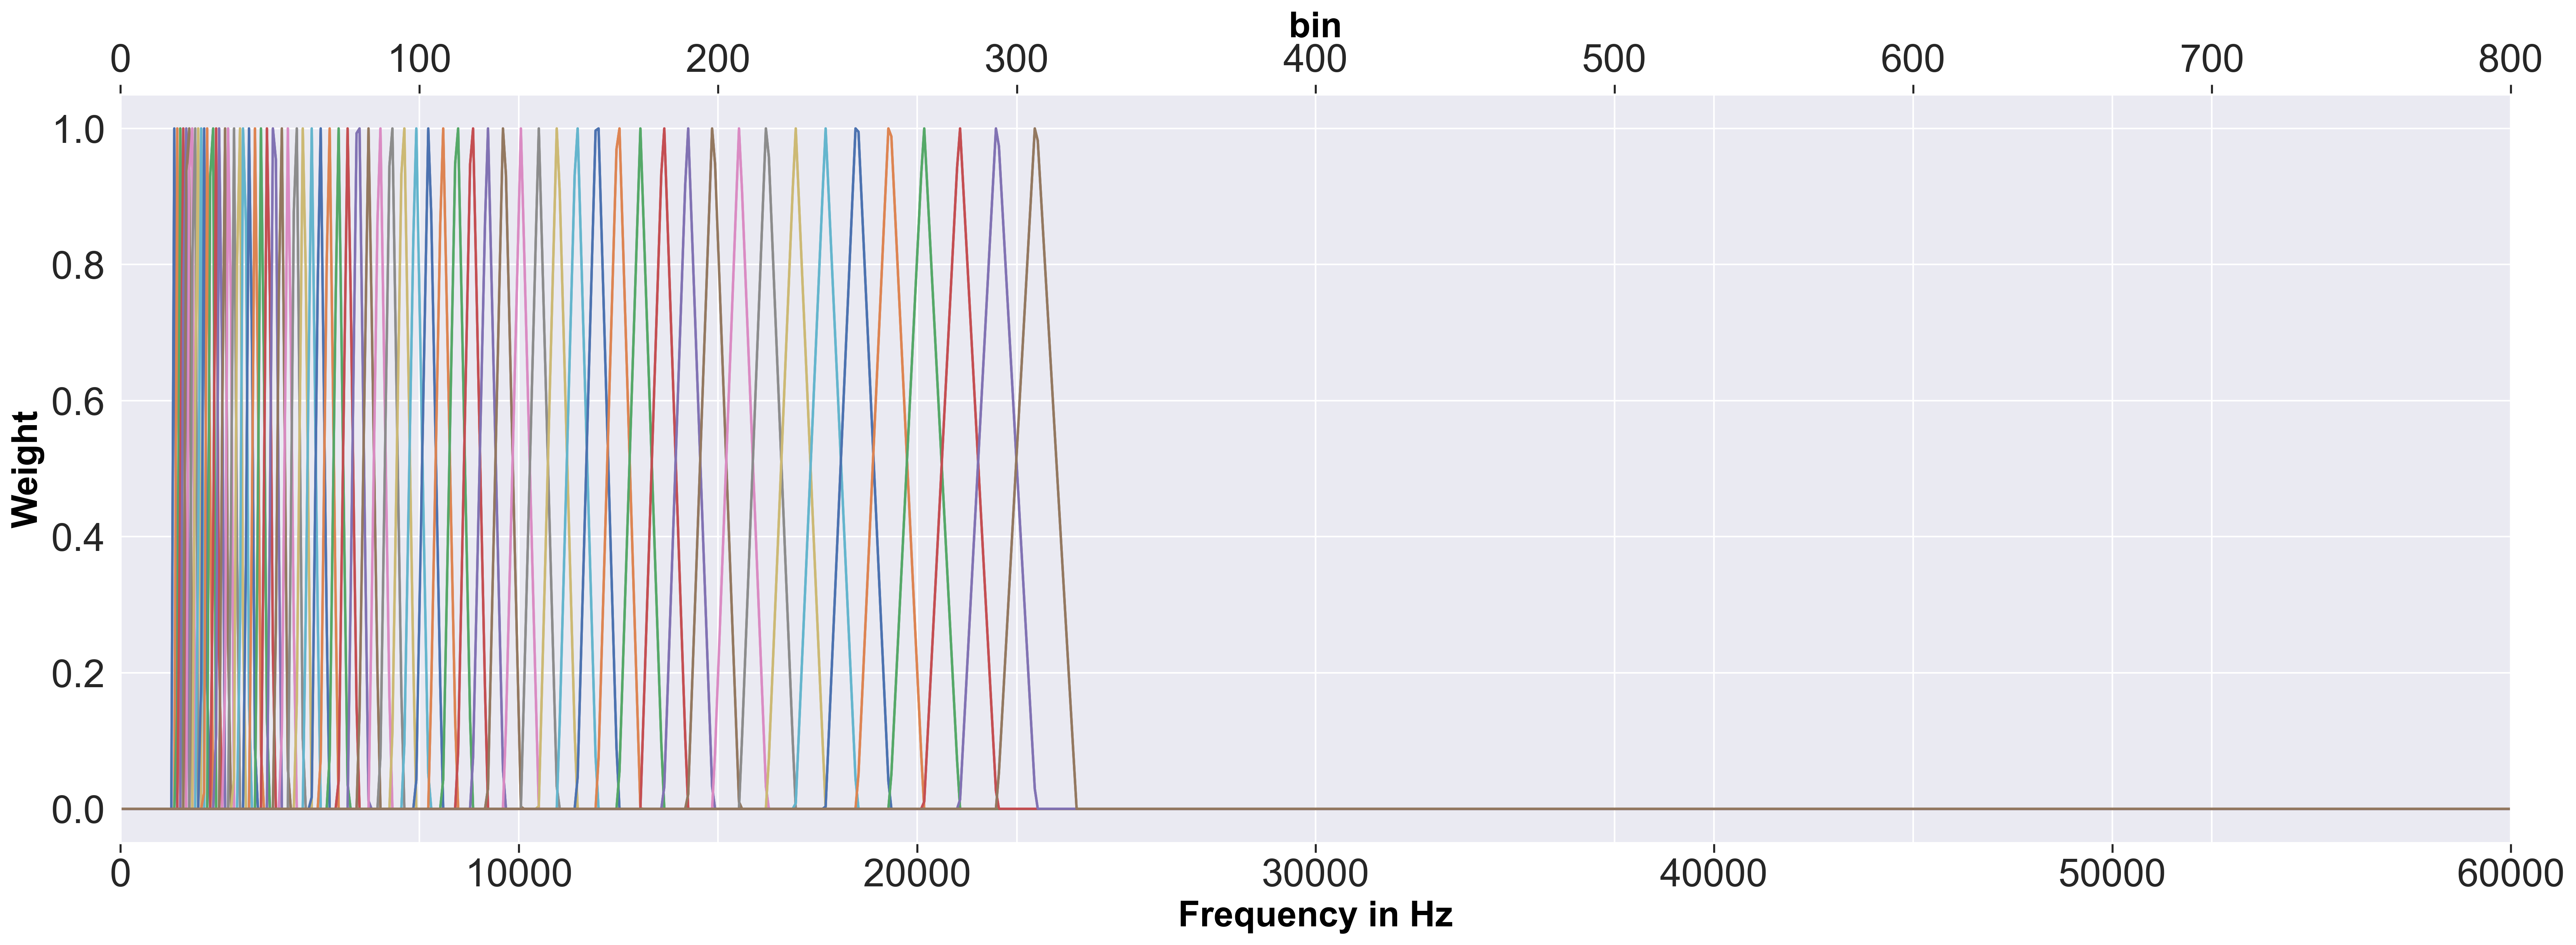

In [14]:
fb.plot()

axis_font = {#'family': 'Times',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }

fig = plt.gcf()
fig.get_axes()[0].set_ylabel("Weight", fontdict=axis_font)
fig.get_axes()[0].set_xlabel("Frequency in Hz", fontdict=axis_font)
fig.get_axes()[1].set_xlabel("bin", fontdict=axis_font)

max_freq = 24000
min_freq = 1300
#fig.get_axes()[0].set(xlim=(min_freq, max_freq))
#fig.get_axes()[1].set(xlim=(fb.freq2bin(min_freq), fb.freq2bin(max_freq)))

## Apply Filterbank
Notice the reduction of dimensionality of the signal.

In [8]:
to_dB = True

log_spec = fb.apply(spec=spec, to_dB=to_dB)

In [9]:
log_spec.shape

(66,)

## Apply DCT
Notice that the result from the DCT does not reduce the dimensionality. We can achieve this by ignoring higher-order coefficients that represent high-frequencies.

In [10]:
from feature_utils import extract_dctc
from scipy.fft import dct, idct

comp_spec = dct(log_spec)

In [11]:
def plot_idct(x, coeffs, use0th):
    N = len(x)
    window = np.zeros(N)
    window[:coeffs] = 1
    window[0] = int(use0th)
    
    yhat = dct(x, norm='ortho')
    x_reconstructed = idct(yhat*window, norm='ortho')

    fig = plt.figure(figsize=(16,6), facecolor='white')

    plt.plot(x, label="original")
    plt.plot(x_reconstructed, label="reconstructed")
    
    plt.legend()
    plt.title("Use the slider above to manipulate the number of dct coefficients used for reconstruction")
    

## Interactive DCT signal reconstruction
The signal can be reconstructed by applying the inverse DCT (IDCT) to the dct coefficients. If we use all DCT coefficients, the signal can be perfectly reconstructed.
If we only use the first N DCT coefficients, the reconstructed signal is a low-pass filtered version of the original signal, which represents the envelope to a certain degree.
Additionally, removing the 0th coefficient only removes the offset related to the overall energy level of the signal.

In [12]:
import ipywidgets as widgets

max_coeffs = len(spec[17:])

dct_slider = widgets.IntSlider(
    value=max_coeffs,
    min=1,
    max=max_coeffs,
    step=1,
    description='dct coefficients:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='90%')
)

check_box = widgets.Checkbox(
    value=True,
    description='use 0th coeff')

widgets.interact(plot_idct,
                 x=widgets.fixed(spec[17:]),
                 coeffs=dct_slider,
                 use0th=check_box);

interactive(children=(IntSlider(value=784, continuous_update=False, description='dct coefficients:', layout=La…

## Plot Summary

NameError: name 'ticker' is not defined

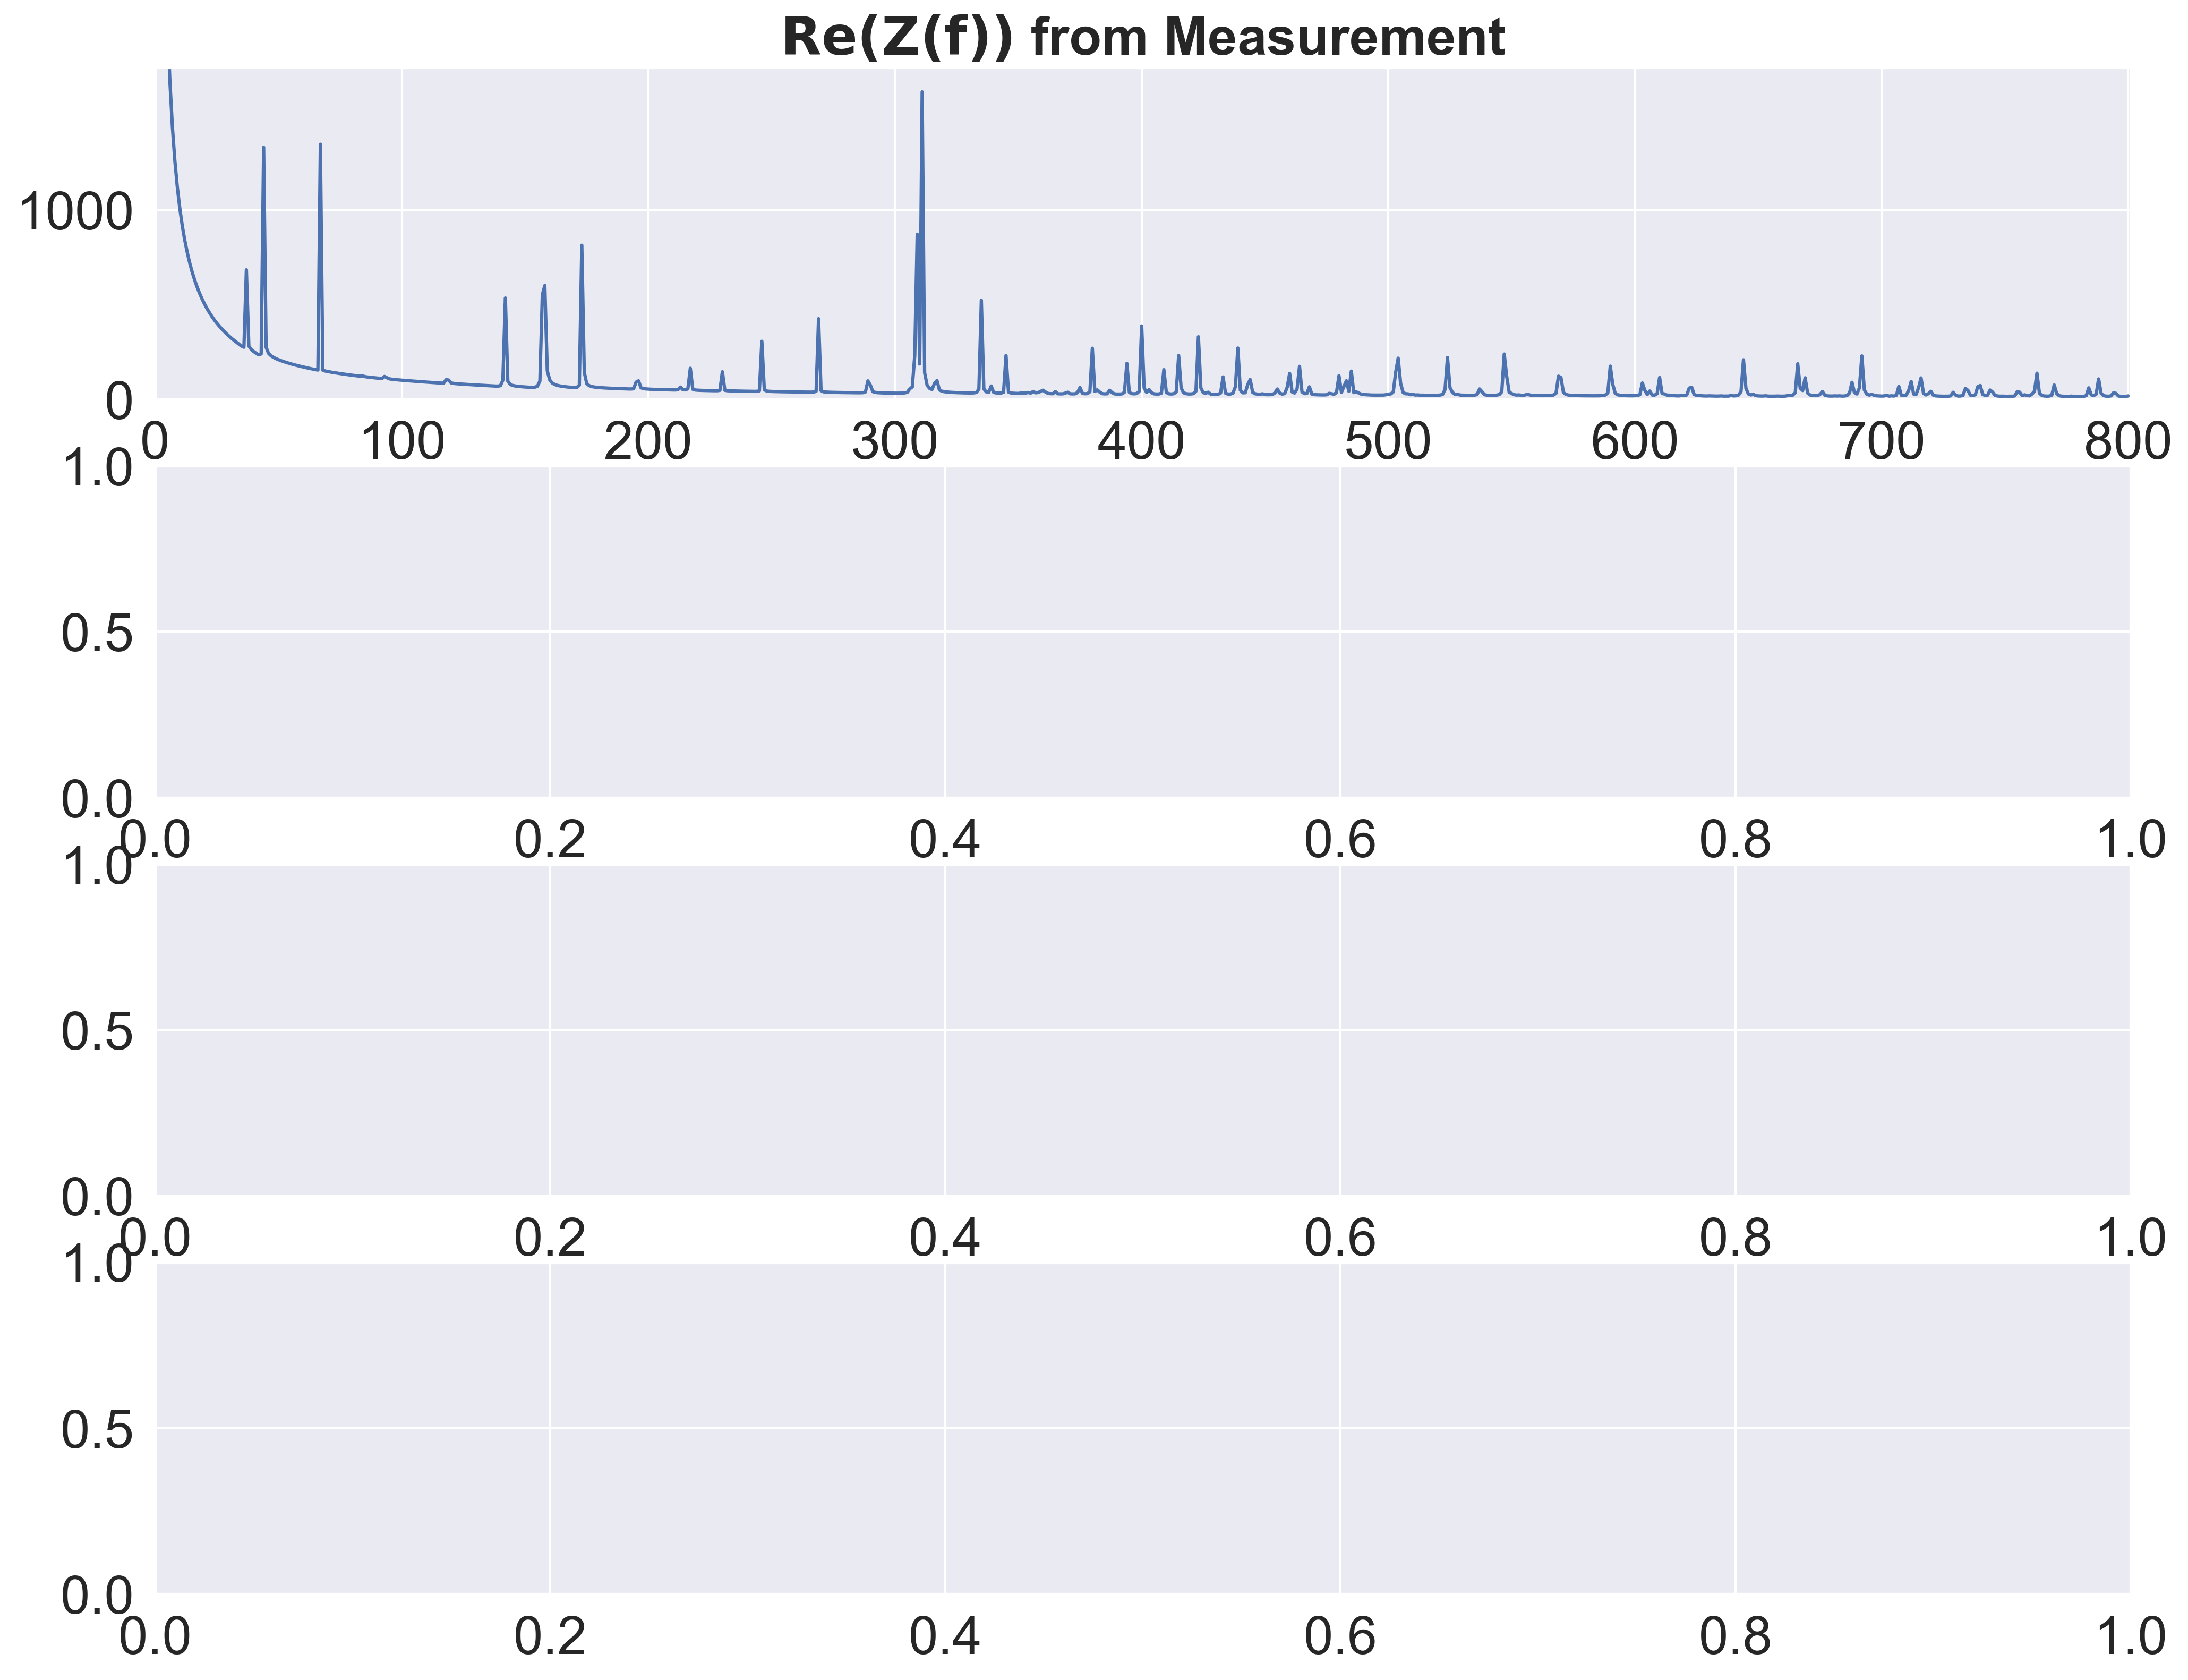

In [13]:
fig = plt.figure(figsize=(16,16), facecolor='white')

# (n_rows, n_cols)
gs = fig.add_gridspec(5,1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])


ax0.plot(spec)
ax0.set_title("$\mathbf{Re(Z(f))}$ from Measurement")
ax0.set(xlim=(0, 801))
ax0.set(ylim=(0, 1750))
ax0.set_xlabel('bin')
ax0.set_ylabel('')
ax0.yaxis.set_major_locator(ticker.NullLocator())



fb.plot(ax1)
ax1.set_title("Filterbank")
ax1.set_ylabel('')
ax1.yaxis.set_major_locator(ticker.NullLocator())


ax2.plot(log_spec)
ax2.set_title("Log-scaled Spectrum")
ax2.set(xlim=(0, 65))
ax2.set_xlabel('bin')
ax2.set_ylabel('')
ax2.yaxis.set_major_locator(ticker.NullLocator())

ax3.plot(comp_spec[1:31])
ax3.set_title("Final Feature Vector after Discrete Cosine Transform")
ax3.set(xlim=(0, 30))
ax3.set_ylabel('')
ax3.yaxis.set_major_locator(ticker.NullLocator())


fig = plt.gcf()
fig.get_axes()[4].set_xlabel('')
fig.get_axes()[4].xaxis.set_major_locator(ticker.NullLocator())

plt.tight_layout()